# Установка зависимостей

In [ ]:
CUDA_CORE=1
MODEL_USED="facebook/nllb-200-distilled-600M"
# MODEL_USED="facebook/nllb-200-1.3B"
LANGUAGE_ORIGIN_LABEL="nivkh_Cyrl"
LANGUAGE_TARGET_LABEL="rus_Cyrl"
LANGUAGE_SIMILAR_LABEL="bak_Cyrl"
LANGUAGE_FILE_ORIGIN_LABEL="nivkh"
LANGUAGE_FILE_TARGET_LABEL="rus"
NORMALIZER_LANGUAGE="ru"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL_SAVE_PATH="/content/drive/MyDrive/models/nllb_nivkh_rus_600M_extended"
!mkdir -p {MODEL_SAVE_PATH}

In [ ]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [ ]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [ ]:
!pip install ipywidgets -q

In [ ]:
!pip install scikit-learn -q
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
import time
from torch import optim
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer
import shutil
import pickle
import os
import re
import json

# Обработка данных

In [ ]:
data = []

input_dir = '/content/drive/MyDrive/translation_resplit3'
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith('.txt'):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)\.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/MyDrive/FilteredNivkhTxt/valid.json') as json_file:
    valid_files = json.load(json_file)

for filename in tqdm(valid_files):
    if filename.endswith('.txt'):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)/n_r_p.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None

  0%|          | 0/253 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(data)
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
14189,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
14190,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
14191,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
14192,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
df['nivkh_norm'] = df['nivkh'].str.lower().str.strip()
df['rus_norm'] = df['rus'].str.lower().str.strip()
df = df.drop_duplicates(subset=['nivkh_norm', 'rus_norm']).drop(columns=['nivkh_norm', 'rus_norm']).reset_index(drop=True)
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
13547,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13548,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13549,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13550,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
def restore_nivkh_capitalization(sents):
    capitalized_sents = []
    char_map = {
    'ӄ': 'Ӄ',
    'ӈ': 'Ӈ',
    'ӽ': 'Ӽ',
    'ғ': 'Ғ',
    'ҳ': 'Ҳ',
    'χ': 'Χ',
    'ӻ': 'Ӻ',
    'р̌': 'Р̌',
    'ӿ': 'Ӿ',
    'ў': 'Ў'
}
    for sent in sents:
        if not sent:
            capitalized_sents.append(sent)
            continue
        first_char = sent[0]
        rest_of_sent = sent[1:]
        if first_char in char_map.keys():
            capitalized_first = char_map[first_char]
        else:
            capitalized_first = first_char.upper()
        capitalized_sent = capitalized_first + rest_of_sent
        capitalized_sents.append(capitalized_sent)
    return capitalized_sents

In [ ]:
df['nivkh'] = restore_nivkh_capitalization(df['nivkh'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
13547,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13548,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13549,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13550,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
ENGLISH_WORDS = re.compile(r'\b[a-zA-Z]+\b')
URLS = re.compile(r'https?://\S+|www\.\S+')
EMAILS = re.compile(r'\S+@\S+')
PHONES = re.compile(r'(\+?\d[\d\s\-()]{6,})')
BRACKETS = re.compile(r'\[[^\]]*\]|\([^\)]*\)')
JUNK = re.compile(r'[~*^%$@#_=<>\\|]')

def clean_text(text):
    text = URLS.sub('', text)
    text = EMAILS.sub('', text)
    text = PHONES.sub('', text)
    text = BRACKETS.sub('', text)
    text = ENGLISH_WORDS.sub('', text)
    text = JUNK.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
def clean_up(sents):
    map = {
        'ь:': 'ь.', 'Ē~ӽ': 'Ех', 'ѵ': 'у', 'Ē': 'Е', 'ā': 'а', 'ñ': '', '×': 'у',
        'ī': 'и', 'Ō': 'О', 'ō': 'о', 'р̃': 'р̌', 'р̆': 'р̌', '~': '-',
        '§.': '', 'ÿ': 'у', 'ʻ': '', 'ʼ': "'", 'р˘': 'р̌', 'р̀': 'р̌',
        '́': '', '̃': '', '̄': '', '̉': '', '̍': '', '̔': 'р', '̣': '',
        '̥': '', '̨': '', '̬': '', '̓': '', 'џ': 'ц', 'ґ': 'г', 'Ҥ': 'Ӈ',
        'Ң': 'Ӈ', 'ң': 'ӈ', 'Ӊ': 'Ӈ', 'ӊ': 'ӈ', 'ҧ': 'п', 'Ұ': 'ӻ',
        'ӗ': 'е', 'Өа х': 'Х', 'ӯ': 'у', 'ӱ': 'у', 'ӧ': 'ё', 'ҳ': 'х',
        '՚': "'", 'ḗ': 'е', 'ṓ': 'о', 'ṕ': 'р̌', '‑': '-', '‐': '-',
        '–': '-', '—': '-', '‘': "'", '’': "'", '“': '"', '”': '"',
        '«': '"', '»': '"', '•': '', '…': '...', '▸': '', 'Р̆': 'Р̌',
        'ē': 'е', 'Ӿ ': '! ', 'Ӿ" ': '!" ', "\\'": "'"
    }
    cleaned_sents = []
    for sent in sents:
        for old, new in map.items():
            sent = sent.replace(old, new)
            sent = clean_text(sent)
        cleaned_sents.append(sent.replace("\\", ""))
    return cleaned_sents

In [ ]:
df['nivkh'] = clean_up(df['nivkh'])
df['rus'] = clean_up(df['rus'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
13547,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13548,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13549,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
13550,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
df['source'] = df['source'].str.replace('srhsh', 'shrsh', regex=False)

In [ ]:
sources = list(set(df['source']))
sources

['ptmn',
 'shtrn',
 'tmn',
 'hrn',
 'nd',
 'shrsh',
 'grz',
 'gdn',
 'shklg',
 'sng',
 'agm',
 'pnf',
 'bible']

In [ ]:
df_train, df_devtest = train_test_split(df, test_size=0.2, random_state=42, stratify=df['source'])
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42, stratify=df_devtest['source'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 10589 to 1666
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   10841 non-null  object
 1   rus     10841 non-null  object
 2   file    10841 non-null  object
 3   source  10841 non-null  object
dtypes: object(4)
memory usage: 423.5+ KB


In [ ]:
df_train.head()

,nivkh,rus,file,source
10589,Йитруд лудьғу.,Осмеивают в песне.,24_shrsh.txt,shrsh
10395,Ӿоӻорот п'нанактох леле умть.,Так он очень обиделся на свою сестру.,16_shrsh.txt,shrsh
10970,Ку сык ӄ'ола нивғгу ӿат'итт лоти дитр̌ йыймдля?,"Говорят, что все те богатые нивхи на русском я...",15_shrsh.txt,shrsh
8427,Киғ-герӄӈа ӈаски ызӈ мут пандхе.,"Хребта Солёного моря хозяйками являясь жившие,",a462_sng.txt,sng
7739,"П' нанӽ ивф п'игта,","На место своей старшей сестры посадили,",a462_sng.txt,sng


In [ ]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1355 entries, 5433 to 6994
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   1355 non-null   object
 1   rus     1355 non-null   object
 2   file    1355 non-null   object
 3   source  1355 non-null   object
dtypes: object(4)
memory usage: 52.9+ KB


In [ ]:
df_dev.head()

,nivkh,rus,file,source
5433,Паӽ муд фуру.,"в камня обернулся, оказывается.",a462_sng.txt,sng
10190,"Ӿы нивғ ывть, ӄот, п'р̌ыта, тукрух пант, пилта.","Вышла замуж, переплыла, приехала и здесь росла...",27_shrsh.txt,shrsh
12956,"Р̌аӈг хируӈан, паӻла тиф пойдь.","Где пробегут, там красный след останется.",/content/drive/MyDrive/FilteredNivkhTxt/71_nd/...,nd
2513,"Ӿуӈ ычих лур̌ луфке итр̌: Нлыхрa, нерах пшыйa.","Этот старик шаманил, долго шаманил, воззвал: О...",a135_shtrn.txt,shtrn
7063,"Пай р̌лы ӿат итнд, и?","Простым небом называемое, верно ведь?",a462_sng.txt,sng


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1356 entries, 1686 to 3121
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   1356 non-null   object
 1   rus     1356 non-null   object
 2   file    1356 non-null   object
 3   source  1356 non-null   object
dtypes: object(4)
memory usage: 53.0+ KB


In [ ]:
df_test.head()

,nivkh,rus,file,source
1686,Ӿаӄ нея.,Шапку надень.,a225_grz.txt,grz
8810,Ивух нанак йивдь ла.,У него старшая сестра есть ли.,a226_tmn.txt,tmn
3238,Ӿуӈ куты-рулк йугыр̌ йугыфке.,"В эту дыру спустился, долго спускался.",a138_shtrn.txt,shtrn
13069,Ӿы ямафкир праздничный мероприятиеғу цикл п'ыл...,В Сахалинском областном центре народного творч...,/content/drive/MyDrive/FilteredNivkhTxt/a356_n...,nd
8762,Чыӈдоӽ маӈгур ниғидьра.,Большое вам спасибо.,a226_tmn.txt,tmn


# Настройка модели

## Настройка токенизатора

In [ ]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [ ]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [ ]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [ ]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,nivkh,nivkh_words,nivkh_toks,rus,rus_words,rus_toks
8935,Нанакух утку ӄ'аудь.,"[Нанакух, утку, ӄ, ', аудь, .]","[▁На, на, ку, х, ▁у, тку, ▁, ӄ, ', ау, дь, .]",У старшей сестры мужа нет.,"[У, старшей, сестры, мужа, нет, .]","[▁У, ▁стар, шей, ▁се, стры, ▁мужа, ▁нет, .]"
11439,"Такр̌ п'иӈан, такр̌ п'иӈан.","[Такр, ̌, п, ', иӈан, ,, такр, ̌, п, ', иӈан, .]","[▁Так, р, ̌, ▁п, ', и, ӈ, ан, ,, ▁так, р, ̌, ▁...","Материковские, материковские.","[Материковские, ,, материковские, .]","[▁Матери, ков, ские, ,, ▁матери, ков, ские, .]"
6014,Андӽ - нивгун нр̌ыд.,"[Андӽ, -, нивгун, нр, ̌, ыд, .]","[▁Анд, ӽ, ▁-, ▁нив, гун, ▁н, р, ̌, ы, д, .]",Гостей-людей вижу.,"[Гостей, -, людей, вижу, .]","[▁Го, стей, -, лю, дей, ▁вижу, .]"
8666,Т'ытки озр чхыф ӈыӈр виӈан.,"[Т, ', ытки, озр, чхыф, ӈыӈр, виӈан, .]","[▁Т, ', ы, тки, ▁оз, р, ▁ч, хы, ф, ▁, ӈ, ы, ӈ,...",Рано утром уходил на охоту.,"[Рано, утром, уходил, на, охоту, .]","[▁Ра, но, ▁у, тром, ▁у, ходи, л, ▁на, ▁охо, ту..."
3624,Йанӻей кузир̌ чатар̌.,"[Йанӻей, кузир, ̌, чатар, ̌, .]","[▁Й, ан, ӻ, ей, ▁ку, зир, ̌, ▁ча, тар, ̌, .]","его жена вышла, стала барабанить.","[его, жена, вышла, ,, стала, барабанить, .]","[▁его, ▁жена, ▁вы, шла, ,, ▁стала, ▁бара, ба, ..."


In [ ]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

<ipython-input-32-8bf0a8236e3f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,nivkh_toks,rus_toks,nivkh_words,rus_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,20.722200,14.194600,9.947800,8.752500
std,18.286861,13.149754,8.491754,7.273248
min,1.000000,2.000000,1.000000,1.000000
25%,10.000000,7.000000,5.000000,4.000000
50%,15.000000,10.000000,7.000000,6.000000
75%,24.000000,16.000000,12.000000,10.000000
max,227.000000,176.000000,98.000000,94.000000


In [ ]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

2.08309374937172
1.6217766352470724


In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [ ]:
texts_with_unk = [text for text in tqdm(df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/13553 [00:00<?, ?it/s]

32


In [ ]:
import random
s = random.sample(texts_with_unk, 5)
s

['Тогда Наӻвгун просто закричал:',
 'Остановились, и схватил её, выташил её из под стола, она произнесла "ӿы ӿы" от смеха так устала.',
 'Верах ызӈ - ызӈр̌',
 'В Четвертый млыӿ обронили',
 'Но теперь буду и так готовить! " - это слова участницы дегустации блюд нивхской кухни, которая прошла в Сахалинском областном краеведческом музее в рамках недели нивхской культуры и языка о "теви ӿорлаӄ" - "вкусном шиповнике", перетертом с косточками и перемешанном с брусникой, сахаром и нерпичьим жиром.']

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/32 [00:00<?, ?it/s]

31


## Расширение словаря

In [ ]:
from collections import Counter
all_texts = df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common()
    if v >= 3 and k not in ' '
])

  0%|          | 0/13553 [00:00<?, ?it/s]

In [ ]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [ ]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=8933,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

In [ ]:
# !pip install protobuf==3.19.4 --force-reinstall

In [ ]:
# !wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

In [ ]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 263178
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 6973

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 263200
6995


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263200. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/6995 [00:00<?, ?it/s]

## Добавление тэга нового языка в токенизатор и модель

In [ ]:
print('nivkh_Cyrl' in tokenizer.get_vocab())
print('rus_Cyrl' in tokenizer.get_vocab())

False
True


In [ ]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_ORIGIN_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
print(tokenizer.convert_ids_to_tokens([263176, 263177, 263178])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'nivkh_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['tsn_Latn', 'tso_Latn', 'tuk_Latn']
[263198, 263199, 263200]


In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

263143 263017


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263201. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(263201, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# Обучение (A100)

## Предварительные шаги

In [ ]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).to('cuda')
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# model.to('cuda')

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(263201, 1024)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(263201, 1024)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwi

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [ ]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 35000

In [ ]:
import json

# losses = []
with open('/content/drive/MyDrive/models/nllb_nivkh_rus_600M_extended/losses.json') as json_file:
    losses = json.load(json_file)
losses

[7.817425727844238,
 8.265685081481934,
 8.358107566833496,
 8.943574905395508,
 7.845389366149902,
 8.398615837097168,
 8.063230514526367,
 8.726017951965332,
 8.738744735717773,
 8.47157096862793,
 8.187285423278809,
 8.231023788452148,
 7.46907901763916,
 8.945457458496094,
 8.627317428588867,
 7.138676643371582,
 8.326909065246582,
 7.76285457611084,
 8.435612678527832,
 8.67638111114502,
 6.686715602874756,
 8.241456985473633,
 7.798306941986084,
 8.610886573791504,
 8.35258674621582,
 8.67037582397461,
 8.382604598999023,
 6.530950546264648,
 8.250557899475098,
 8.399903297424316,
 8.58444881439209,
 6.199997901916504,
 7.887880325317383,
 8.056205749511719,
 7.350499153137207,
 7.20273494720459,
 8.463422775268555,
 6.084478855133057,
 7.5887532234191895,
 6.948749542236328,
 6.7778000831604,
 7.704516410827637,
 6.560283660888672,
 8.015115737915039,
 6.6866912841796875,
 8.406716346740723,
 8.877585411071777,
 8.416025161743164,
 8.07345199584961,
 7.549813747406006,
 7.999421

In [ ]:
# losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [ ]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(["П'сутот т'еӽт ло."], ['Помывшись, выбрались.'], 'nivkh_Cyrl', 'rus_Cyrl')


## Циклы обучения (по тренировочным шагам)

In [ ]:
#@title 0-11k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/25000 [00:00<?, ?it/s]

0 7.817425727844238
1000 5.265292939662934
2000 3.196807312011719
3000 2.6216320954561234
4000 2.285901338458061
5000 1.9911514275074005
6000 1.798569351196289
7000 1.5896815234422683
8000 1.4170874699354172
9000 1.2409437437057496
10000 1.107191525131464
11000 0.9921968391835689


In [ ]:
#@title 11-30k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/17015 [00:00<?, ?it/s]

13000 0.7721660158932209
14000 0.7585246074795723
15000 0.7011271470487118
16000 0.6097495744526387
17000 0.541530007109046
18000 0.4724341176152229
19000 0.4208584257811308
20000 0.37215544167160985
21000 0.32132326313108206
22000 0.29371621822565797
23000 0.25630324728786946
24000 0.23395812536031008
25000 0.20767496506497263
26000 0.184567918241024
27000 0.16872266705706715
28000 0.15163500721007586
29000 0.1380157858505845


In [ ]:
#@title 30-35k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/4999 [00:00<?, ?it/s]

31000 0.11175829267688095
32000 0.1176996245086193
33000 0.11529798376001418


KeyboardInterrupt: 

<Axes: >

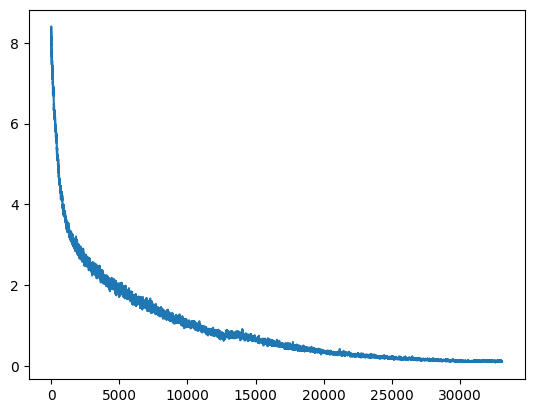

In [ ]:
pd.Series(losses).ewm(10).mean().plot()

In [ ]:
!ls -alsh $MODEL_SAVE_PATH

total 2.4G
1.1M -rw------- 1 root root 1.1M May 30 11:34 all_texts_file.csv
1.0K -rw------- 1 root root  922 May 30 21:08 config.json
 512 -rw------- 1 root root  184 May 30 21:08 generation_config.json
650K -rw------- 1 root root 650K May 30 21:08 losses.json
2.4G -rw------- 1 root root 2.4G May 30 21:09 pytorch_model.bin
4.8M -rw------- 1 root root 4.8M May 30 13:03 sentencepiece.bpe.model
3.5K -rw------- 1 root root 3.5K May 30 21:09 special_tokens_map.json
432K -rw------- 1 root root 432K May 30 11:34 spm_16k.model
207K -rw------- 1 root root 207K May 30 11:34 spm_16k.vocab
4.8M -rw------- 1 root root 4.8M May 30 11:34 spm_nllb_268k.model
1.0K -rw------- 1 root root  570 May 30 21:09 tokenizer_config.json


# Тестирование

In [ ]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Сынок, голоден, котел поставь, воды налей, потом вон в тот амбар взберись, мяса возьми, жиру возьми, принеси, сварн, ешь.']
['Олa, кырхaй, ван рочрa, чар-мар̌крa, ӿарор̌ е-е-ӿеӈ норох теӻыр̌, тур керa, ӈох герa, шор̌-мaғыр̌ йер̌ инийa.']
['Олa, кырндрa, ван рочр чах перйa, ӿарор̌ ехос-пшыр̌, ӈарми чир̌, тамх-тaй, чо наныгйa шор̌-теӻар̌ инйa.']


In [ ]:
t = "Ӿы нивх лу?"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Этого человека?']


In [ ]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Этого человека?']

In [ ]:
t = "Это правда!"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['Ӿунд махтур̌ та!']


In [ ]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Тунд махтур̌ та!']

In [ ]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/1356 [00:00<?, ?it/s]

  0%|          | 0/1356 [00:00<?, ?it/s]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)

In [ ]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 15.97 42.3/18.0/11.1/8.0 (BP = 0.991 ratio = 0.991 hyp_len = 9777 ref_len = 9870)
chrF2++ = 37.27
BLEU = 18.77 46.8/22.1/14.3/10.0 (BP = 0.957 ratio = 0.958 hyp_len = 11144 ref_len = 11628)
chrF2++ = 37.42


In [ ]:
from collections import defaultdict

# метрики по источникам
scores = defaultdict(dict)
for src, df in df_test.groupby('source'):
    # rus --> nivkh
    refs_n2r = [df[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]
    preds_n2r = df[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist()
    scores[src]['bleu_NR'] = bleu_calc.corpus_score(preds_n2r, refs_n2r)
    scores[src]['chrf_NR'] = chrf_calc.corpus_score(preds_n2r, refs_n2r)
    # nivkh --> rus
    refs_r2n = [df[LANGUAGE_FILE_TARGET_LABEL].tolist()]
    preds_r2n = df[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist()
    scores[src]['bleu_RN'] = bleu_calc.corpus_score(preds_r2n, refs_r2n)
    scores[src]['chrf_RN'] = chrf_calc.corpus_score(preds_r2n, refs_r2n)

for src, s in scores.items():
    print(src)
    print('--------')
    for name, val in s.items():
        print(f'{name}: {val}')
    print()

# перепутаны NR и RN

agm
--------
bleu_NR: BLEU = 3.75 9.1/5.0/2.8/1.6 (BP = 1.000 ratio = 1.100 hyp_len = 11 ref_len = 10)
chrf_NR: chrF2++ = 7.99
bleu_RN: BLEU = 3.23 23.1/4.2/2.3/1.2 (BP = 0.794 ratio = 0.812 hyp_len = 13 ref_len = 16)
chrf_RN: chrF2++ = 12.05

bible
--------
bleu_NR: BLEU = 13.13 44.5/18.9/10.0/4.9 (BP = 0.920 ratio = 0.923 hyp_len = 683 ref_len = 740)
chrf_NR: chrF2++ = 33.74
bleu_RN: BLEU = 10.76 47.9/17.3/7.6/3.4 (BP = 0.887 ratio = 0.893 hyp_len = 681 ref_len = 763)
chrf_RN: chrF2++ = 29.21

gdn
--------
bleu_NR: BLEU = 3.96 33.7/6.8/1.3/0.8 (BP = 1.000 ratio = 1.031 hyp_len = 101 ref_len = 98)
chrf_NR: chrF2++ = 22.40
bleu_RN: BLEU = 3.36 34.2/5.1/1.2/0.7 (BP = 0.973 ratio = 0.974 hyp_len = 111 ref_len = 114)
chrf_RN: chrF2++ = 19.04

grz
--------
bleu_NR: BLEU = 24.95 60.3/30.9/16.2/12.8 (BP = 1.000 ratio = 1.035 hyp_len = 146 ref_len = 141)
chrf_NR: chrF2++ = 50.69
bleu_RN: BLEU = 47.82 76.0/53.4/41.5/31.9 (BP = 0.994 ratio = 0.994 hyp_len = 154 ref_len = 155)
chrf_RN: chrF2++ =

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_test.sample(30, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,rus,nivkh,rus_translated,nivkh_translated
3669,Я здесь твоего отца убив съел.,Ни тузух чер̌ кут инихарындрa.,"Я, здесь тебя убив, съем.",Ни тус тытк-тыфк алс пшындрa.
6146,"Как родился, в лености пребывая, ничего не познал,","Пан ба т'акыр нудзиӈ ағзуд,","Выросший совсем никого не видел,","Яӈгур̌, мраӈги фиӈ ӿагин яғзур̌,"
5793,"- Ты что-нибудь, что-нибудь видел ли?","- Чин нуд авр, нуд авр иды ло?","- Ты что-нибудь, что-нибудь видел ли?","Чин нуд авр, нуд авр иды ло?"
7411,Как искать пойдём?,Т'амдин ӈанғн вийд ӿара?,Как бы как бы уйти?,Яӈгут виныдьӈа?
9709,Я много медведей убил.,Ни эрғали чӈыв лый ӿағар.,Я много медведей убивал.,Ни малӻола чӈыф к'удь.
8464,Вмятину сделал - так пребывает.,Ӿолӄир̌ ӿунвд ру.,Так и пребывает.,а лытр̌ ӿунв фуру.
6567,"На того, на котором прежде сидел, сел.","П'и тафка ир̌пда р̌ивра,","На своем доме верхом сел,",Ку т'афк ивф т'ивть.
10991,Все обычаи русские только держим уже.,Сык лоти рор пак поӈан ыр̌к.,Сейчас всё только русские.,Сык нивхгу ӿы лотигу пак т'ури ныра.
3830,"дрова рубя, будете жечь, рыбу будете есть, так живите.","Чхар̌ тан шувнa, чо наныгын ихун ининa, ӿан ӿуныве.","дров нарубив, отрезав рыбы, убив, будем есть.",а наныгытa кржызд ининд ӿунывындхунтa.
4788,"Его младший брат, лишь голову опустивши, пребывает,","Й асӄа к'отр бы нара,","Его младший брат, лишь находясь в молчании, пребывает,","Й асӄа тёӈр̌ пыр̌к ӻотьр̌ ӿунвра,"


# Сохранение на HF

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

model_load_name = "/content/drive/MyDrive/models/nllb_nivkh_rus_600M_extended"
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name, config=cfg)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "nllb_nivkh_rus_600M_extended"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
No files have been modified since last commit. Skipping to prevent empty commit.


pytorch_model.bin:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-izm/nllb_nivkh_rus_600M_extended/commit/995fd324975625e7abcf98a1111e6f37e5662d0a', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='995fd324975625e7abcf98a1111e6f37e5662d0a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/el-izm/nllb_nivkh_rus_600M_extended', endpoint='https://huggingface.co', repo_type='model', repo_id='el-izm/nllb_nivkh_rus_600M_extended'), pr_revision=None, pr_num=None)